# Classifying Forex Currency Pairs Price Direction


In [ ]:
#import
#
#import
import json
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import datetime
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import scipy as sp
from scipy import stats
from scipy.stats import ttest_ind_from_stats
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import statsmodels.api as sm
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics.scorer import make_scorer
from sklearn.tree import DecisionTreeClassifier
import sklearn.linear_model
import sklearn.svm
from sklearn.ensemble import GradientBoostingClassifier #For Classification
from sklearn.ensemble import AdaBoostClassifier
from sklearn.grid_search import GridSearchCV
#from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
import scipy.stats as sp
from sklearn import svm
from sklearn.model_selection import cross_val_score
from scipy.stats.stats import pearsonr


### Getting Data
Get open, close, high and low values of USD/CHF in the last 15 years (2003-2017) from Yahoo Finance Api

In [ ]:
#download data
#download data
symbol = 'CHF=X'
y = 15

x=datetime.datetime.now().year
currency = pd.DataFrame()
for i in range(y):
    n = x-i
    startDate = '%d-01-01' % n
    endDate = '%d-12-31' %n
    print(startDate, endDate)
    url = 'https://query.yahooapis.com/v1/public/yql?q=select * from yahoo.finance.historicaldata where symbol = "%s" and startDate = "%s" and endDate = "%s"&format=json&diagnostics=true&env=store://datatables.org/alltableswithkeys&callback=' % (symbol,startDate,endDate)
    req = requests.get(url)
    req=req.json()
    j = [j for j in req['query']['results']['quote'] ]
    currency = currency.append(pd.DataFrame(j), ignore_index=True)
    
n = ['Date','Open','Close','High','Low']
currency = currency[n]
currency['Pips']=round((pd.to_numeric(currency.Open)-pd.to_numeric(currency.Close))*100000)


currency=currency.reindex(index=currency.index[::-1])
currency=currency.reset_index(drop= True)
     
 

This is how our 3544 observations look like after calculating pips sizes and adding it to the table.
Next step is to divide the data into a training and a testing set of 3100 and 444 observations respectively

In [462]:
currency.head()

,Date,Open,Close,High,Low,Pips
0,2003-09-17,1.3814,1.3807,1.384,1.3743,70.0
1,2003-09-18,1.3802,1.3858,1.3868,1.3747,-560.0
2,2003-09-19,1.3856,1.3669,1.3865,1.3653,1870.0
3,2003-09-22,1.3563,1.3528,1.3632,1.3502,350.0
4,2003-09-23,1.3527,1.3587,1.3597,1.3419,-600.0


In [202]:
#divide testing & training data

Xtrain = currency[0:3100]
Ytrain = currency[0:3100].Pips>0

Xtest = currency[3100:len(currency)]
Ytest = currency[3100:len(currency)].Pips>0

Xtest= Xtest.reset_index(drop = True)
Ytest= Ytest.reset_index(drop = True)

I calculated technical indicators using "talib" library which I couldn't get it working in python 3 so I created another code which you can find it in the same directory.

You can find technical indicators used in the following links

* http://mrjbq7.github.io/ta-lib/func_groups/overlap_studies.html
* http://mrjbq7.github.io/ta-lib/func_groups/momentum_indicators.html

I used 45 technical indicators functions applied on training set and test set, each technical indicator is calculated using multiple time frames (2,3,5,9,12,20,30) producing 266 features which you can find them in the next shown table

 ** Please note that all the following data pre-processing steps are done seperately on the test set and training set **

In [119]:
#write data to csv to process them in another script using python2
Xtrain.to_csv('chftrain', sep='\t', index = False)
Xtest.to_csv('chftest', sep='\t', index = False)

In [98]:
#get data after processing
titrain= pd.read_csv("tichftrain", sep = "\t")
titest= pd.read_csv("tichftest", sep = "\t")

In [464]:
titrain.head()

,upperband3,middleband3,lowerband3,upperband5,middleband5,lowerband5,upperband9,middleband9,lowerband9,upperband12,...,ultosc3,ultosc5,ultosc9,ultosc12,ultosc20,willr3,willr5,willr9,willr12,willr20
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.393767,1.377800,1.361833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-92.558140,NaN,NaN,NaN,NaN
3,1.395539,1.368500,1.341461,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-92.896175,NaN,NaN,NaN,NaN
4,1.371030,1.359467,1.347903,1.394152,1.36898,1.343808,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-62.331839,-62.583519,NaN,NaN,NaN


Another data pre-processing step is to divide pips sizes into 8 chuncks.
This is how it goes, we take the first 200 observations and divide pips into chunks then the second 200 observations and so on, this is because variations of pips sizes varies a lot from one period to another as shown in the next plot

Pips are divided according to the following quantiles 12.5, 25, 50, 75 percentiles

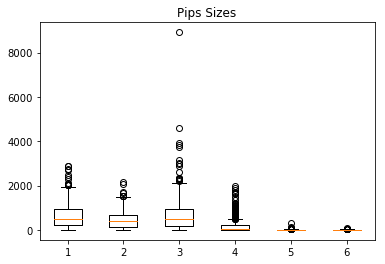

In [495]:
#
plt.boxplot([abs(Xtrain.Pips[0:500]),abs(Xtrain.Pips[500:1000]), abs(Xtrain.Pips[1000:1500]), abs(Xtrain.Pips[1500:2000]), abs(Xtrain.Pips[2000:2500]), abs(Xtrain.Pips[2500:3000])])
plt.title("Pips Sizes")
plt.show()

In [101]:
#Create quantiles for Pips
q=[]
for j in list(range(0,len(Xtrain), 200)):
    
    ind1=j
    ind2=j+200
    if j+200 > len(Xtrain):
        ind2 = len(Xtrain)
    
    p = np.asarray(Xtrain.Pips[ind1:ind2])

    
    for i in range(len(p)):
        if p[i] <= np.percentile(p,0.125*100):
            q.append(1)
        elif p[i] <= np.percentile(p,0.25*100):
            q.append(2)
        elif p[i] <= np.percentile(p,0.375*100):
            q.append(3)
        elif p[i] <= np.percentile(p,0.5*100):
            q.append(4)
        elif p[i] <= np.percentile(p,0.625*100):
            q.append(5)
        elif p[i] <= np.percentile(p,0.75*100):
            q.append(6)
        elif p[i] <= np.percentile(p,0.875*100):
            q.append(7)
        else:
            q.append(8)
            
            

q2=[]
for j in list(range(0,len(Xtest), 200)):
    
    ind1=j
    ind2=j+200
    if j+200 > len(Xtest):
        ind2 = len(Xtest)
    
    p = np.asarray(Xtest.Pips[ind1:ind2])

    
    for i in range(len(p)):
        if p[i] <= np.percentile(p,0.125*100):
            q2.append(1)
        elif p[i] <= np.percentile(p,0.25*100):
            q2.append(2)
        elif p[i] <= np.percentile(p,0.375*100):
            q2.append(3)
        elif p[i] <= np.percentile(p,0.5*100):
            q2.append(4)
        elif p[i] <= np.percentile(p,0.625*100):
            q2.append(5)
        elif p[i] <= np.percentile(p,0.75*100):
            q2.append(6)
        elif p[i] <= np.percentile(p,0.875*100):
            q2.append(7)
        else:
            q2.append(8)
            
Xtrain['q']=q
Xtest['q']=q2                        

One more set of features to add is the percentage of change of each feature in each observation.

In [104]:
#join tables and shift observations
Xtrain = Xtrain.join(titrain)
Xtest = Xtest.join(titest)
Xtrain['d']=Xtrain.Pips<0
Xtest['d']=Xtest.Pips<0
Ytrain=Xtrain.d
Ytest=Xtest.d
YYtrain= []
YYtrain.append(np.nan)
for i in range(1, len(Xtrain)):
    if Xtrain.Close.values[i]<Xtrain.Close.values[i-1]:
        YYtrain.append(0)
    else:
        YYtrain.append(1)

        
YYtest=[]
YYtest.append(np.nan)
for i in range(1, len(Xtest)):
    if Xtest.Close.values[i]<Xtest.Close.values[i-1]:
        YYtest.append(0)
    else:
        YYtest.append(1)        





YYtrain= pd.Series(YYtrain)
YYtest= pd.Series(YYtest)


Xtrain['dccc']= YYtrain.values
Xtest['dccc']= YYtest.values


PC=pd.DataFrame()
#cols=[]
for i in Xtrain.columns:
    if i == 'Date':
        continue
    ti = i+'PC'
    
    col=[]
    col.append(np.nan)
    flag=0
    for j in range(1, len(Xtrain)):
        
        if not float(Xtrain[i][j-1]):
            tt=np.mean(pd.to_numeric(Xtrain[i]))
            col.append((float(Xtrain[i][j])-float(Xtrain[i][j-1]))/abs(tt))
            continue
            
        col.append((float(Xtrain[i][j])-float(Xtrain[i][j-1]))/abs(float(Xtrain[i][j-1])))
        
    PC[ti]=col
        
Xtrain = Xtrain.join(PC)
#print(cols)

PC=pd.DataFrame()
for i in Xtest.columns:
    if i == 'Date':
        continue
    ti = i+'PC'
    
    col=[]
    col.append(np.nan)
    flag=0
    for j in range(1, len(Xtest)):
        
        if not float(Xtest[i][j-1]):
            tt=np.mean(pd.to_numeric(Xtest[i]))
            col.append((float(Xtest[i][j])-float(Xtest[i][j-1]))/abs(tt))
            continue
            
        col.append((float(Xtest[i][j])-float(Xtest[i][j-1]))/abs(float(Xtest[i][j-1])))
        
    PC[ti]=col
        
Xtest = Xtest.join(PC)

YQtrain = Xtrain.q
YQtest = Xtest.q

cols = [i for i in Xtrain.columns if i not in ["Date"]]
Xtrain[cols] = Xtrain[cols].shift(1)


cols = [i for i in Xtest.columns if i not in ["Date"]]
Xtest[cols] = Xtest[cols].shift(1)


Xtrain = Xtrain.drop(["Date"], axis=1)
Xtest = Xtest.drop(["Date"], axis=1)


####

Xtrain=Xtrain.reset_index(drop=True)
Xtest=Xtest.reset_index(drop=True)
Ytrain=Ytrain.reset_index(drop=True)
Ytest=Ytest.reset_index(drop=True)
YQtrain = YQtrain.reset_index(drop=True)
YQtest = YQtest.reset_index(drop=True)


Xtrain=Xtrain.dropna()
Xtest=Xtest.dropna()

YQtrain=YQtrain[Xtrain.index]
YQtest=YQtest[Xtest.index]
YYtrain=YYtrain[Xtrain.index]
YYtest=YYtest[Xtest.index]
Ytrain=Ytrain[Xtrain.index]
Ytest=Ytest[Xtest.index]


Xtrain=Xtrain.reset_index(drop=True)
Xtest=Xtest.reset_index(drop=True)
Ytrain=Ytrain.reset_index(drop=True)
Ytest=Ytest.reset_index(drop=True)
YYtest=YYtest.reset_index(drop=True)
YYtrain=YYtrain.reset_index(drop=True)
YQtrain = YQtrain.reset_index(drop=True)
YQtest = YQtest.reset_index(drop=True)

Now we are done with data pre-processing.

This is how our training and data sets look like.

In [501]:
#
print("Number of observations in Training set: %d"%(Xtrain.shape[0]))
print("Number of observations in Test set: %d"%(Xtest.shape[0]))
print("Number of features: %d"%(Xtest.shape[1]))
Xtrain.head()

Number of observations in Training set: 2984
Number of observations in Test set: 327
Number of features: 548


,Open,Close,High,Low,Pips,q,upperband3,middleband3,lowerband3,upperband5,...,ultosc9PC,ultosc12PC,ultosc20PC,willr3PC,willr5PC,willr9PC,willr12PC,willr20PC,dPC,dcccPC
0,1.2422,1.2590,1.2615,1.2392,-1680.0,1.0,1.266341,1.252167,1.237992,1.269951,...,0.057797,0.074901,0.043381,0.650214,0.540346,0.685950,0.685950,0.685950,2.30312,1.977664
1,1.2591,1.2662,1.2705,1.2573,-710.0,2.0,1.275798,1.255867,1.235935,1.272262,...,0.057436,-0.035274,-0.016574,0.501280,0.484225,0.476482,0.476482,0.476482,0.00000,0.000000
2,1.2665,1.2614,1.2756,1.2607,510.0,6.0,1.268187,1.262200,1.256213,1.272935,...,-0.197933,-0.041162,-0.014582,-1.984794,-2.145900,-2.008401,-2.008401,-2.008401,-1.00000,-1.000000
3,1.2576,1.2684,1.2707,1.2563,-1080.0,2.0,1.271179,1.265333,1.259488,1.277818,...,0.173254,0.066550,0.029489,0.043713,0.492958,0.492958,0.492958,0.492958,2.30312,1.977664
4,1.2685,1.2974,1.2985,1.2672,-2890.0,1.0,1.306903,1.275733,1.244564,1.298215,...,0.254452,0.074107,0.077867,0.930128,0.902099,0.865113,0.890846,0.890846,0.00000,0.000000


In [446]:
#Functions - mscore - changethr - fscorecols - treecols
def mscore(yactual, ypred):
    l=len(yactual)
    m = max(sum(yactual), l-sum(yactual))
    res1 = m/l
    err=0
    t=[int(i) for i in yactual]
    for i in range(l):
        tt = ypred[i]
        #t = yactual[i]
        if(tt!=t[i]):
        #if(2!=3):
            err=err+1
            
    err = 1- (err/l)
    #print(err)
    #print(res1)
    return err-res1

ms = make_scorer(mscore, greater_is_better=True)


def treecols(Xtrain, Ytrain, GB):
    importance_list = GB.feature_importances_
    name_list = Xtrain.columns
    importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
    return importance_list[::-1], name_list[::-1]
    

I will use Gradient Boosting Trees to classify negative and positive movements of closing price value.

Below, the classifier is trained using all features then I plot and extract the most effective features

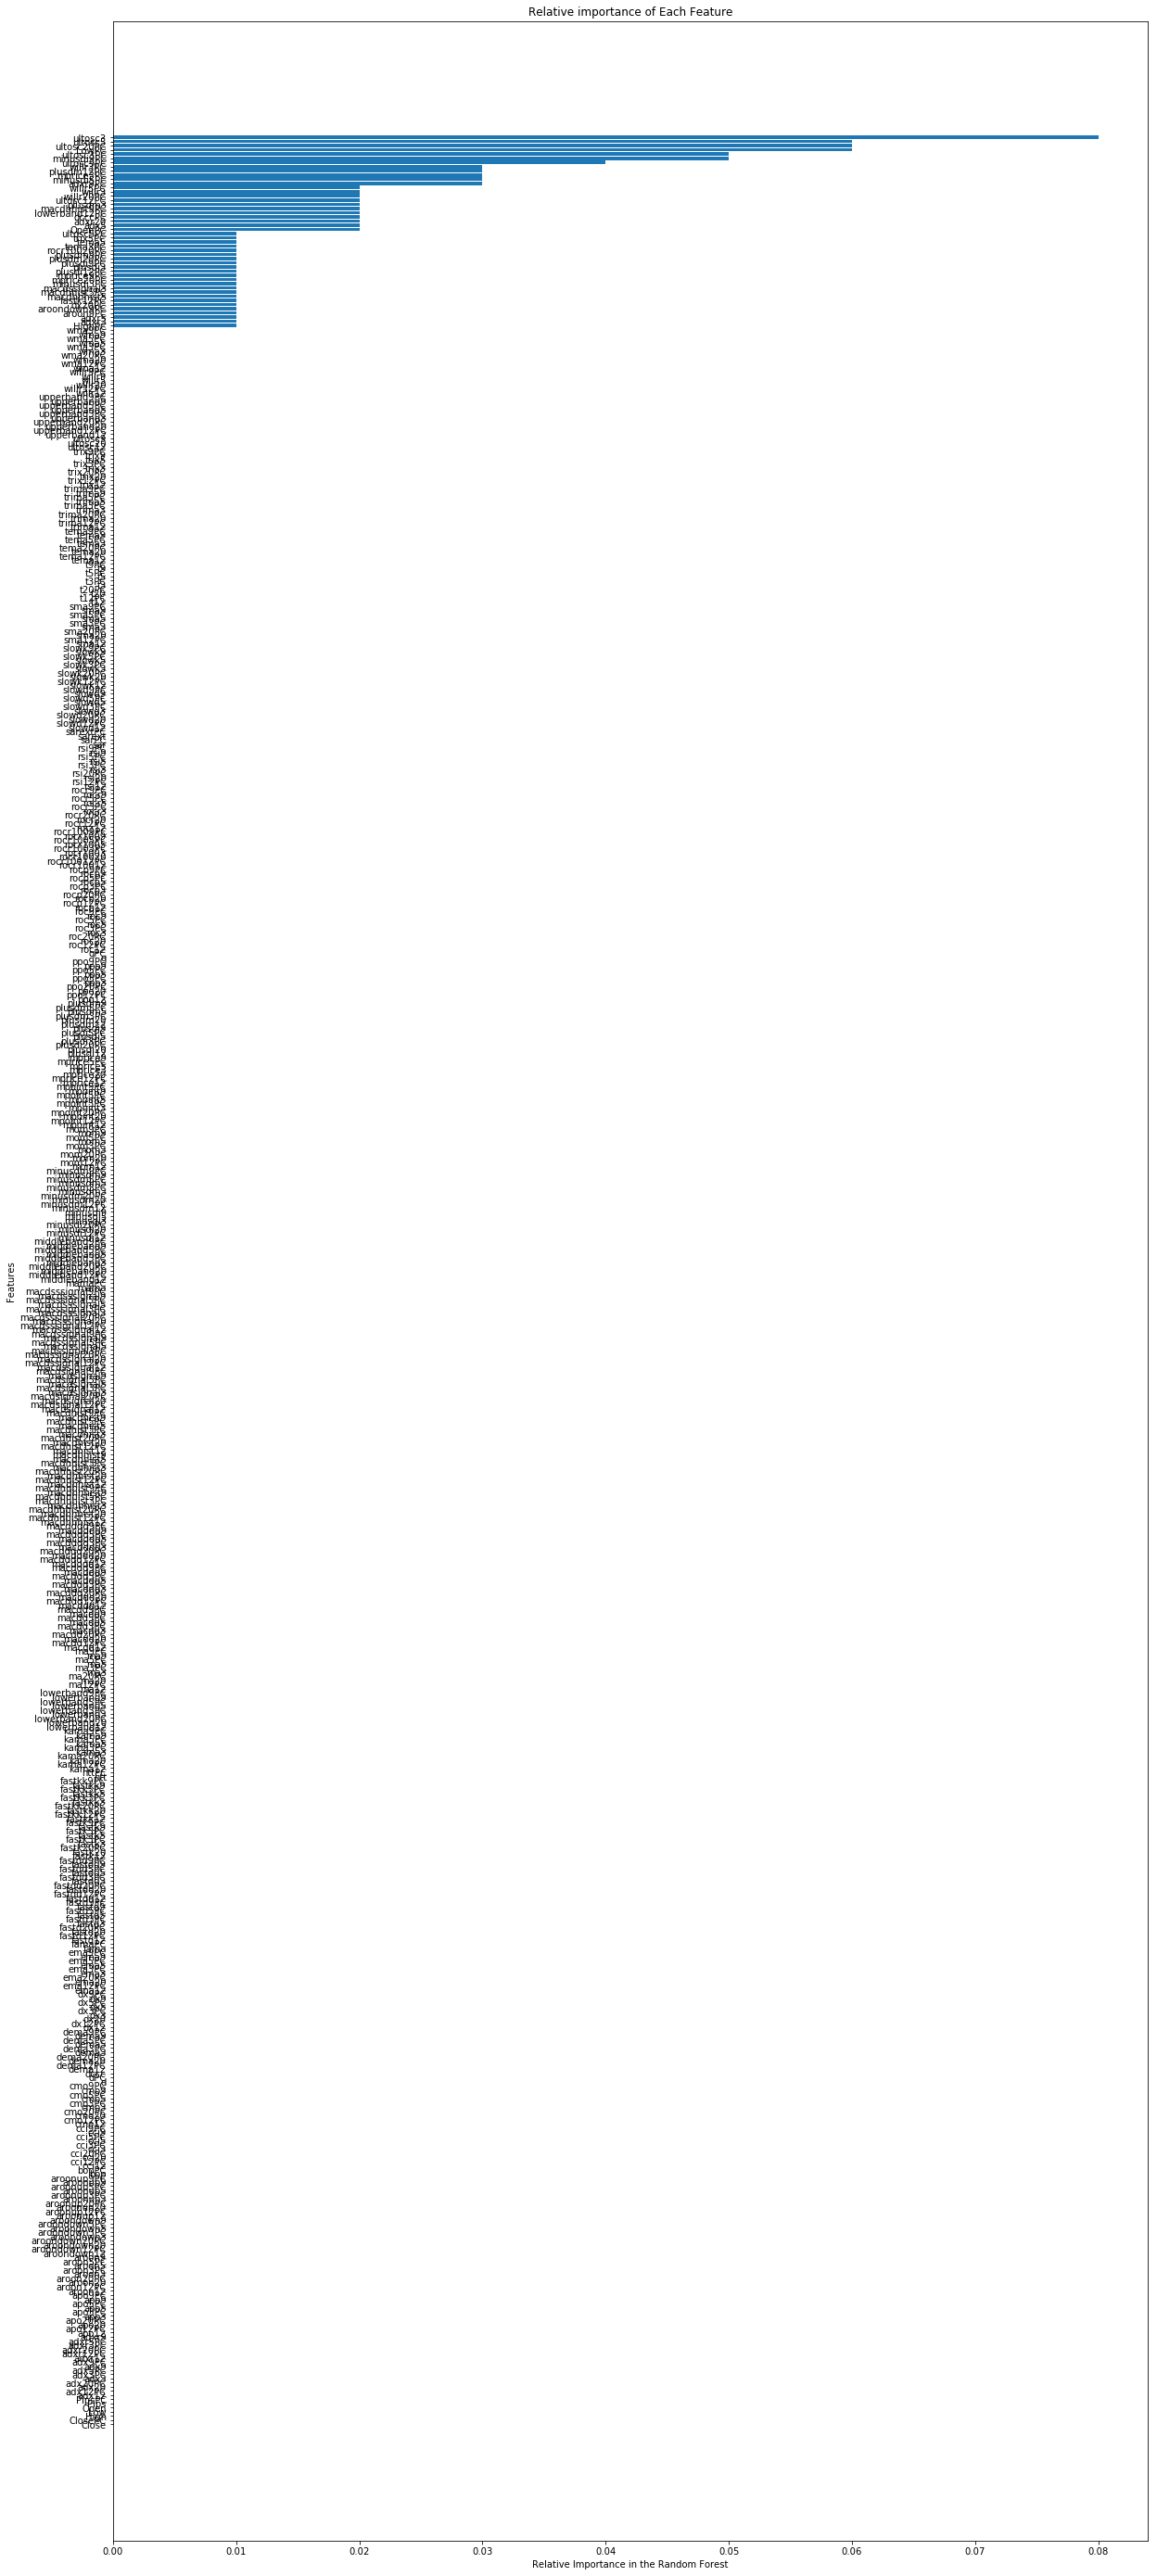

In [447]:
#get best features
GB=GradientBoostingClassifier(n_estimators=100, min_impurity_split=500, max_depth=1).fit(Xtrain, YYtrain)
#  select important features 
treenames_scores, treenames = treecols(GB=GB, Xtrain=Xtrain, Ytrain=YYtrain)
treenames_scores=pd.Series(treenames_scores)
treenames=pd.Series(treenames)
bestFeatures= treenames[treenames_scores>0]


plt.figure(figsize=(20,50))
importance_list = treenames_scores
name_list = treenames
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

A feature is effective when the classifier produces more error when it excludes the feature, I chose the features that don't have effect on error when excluded. 46 features are selected.

A feature that has suffix "PC" refers to "Percentage of change" that we calculated earlier for each feature. Notice that PC-Features are dominating.

In [503]:
#most effective features
bestFeatures

0           ultosc3
1           ultosc5
2        ultosc20PC
3             LowPC
4         ultosc3PC
5        minusdi9PC
6         ultosc9PC
7          willr3PC
8        plusdm12PC
9         mprice3PC
10       minusdi5PC
11          adxr9PC
12         willr5PC
13           willr3
14        willr20PC
15       ultosc12PC
16          plusdm3
17     macdhhist9PC
18    lowerband12PC
19           dcccPC
20           adxr20
21             adx5
22           OpenPC
23        ultosc5PC
24          trix5PC
25            tema5
26          tema3PC
27      rocr10020PC
28        plusdm9PC
29       plusdm20PC
30        plusdi9PC
31          plusdi3
32       plusdi12PC
33        mprice9PC
34       mprice20PC
35       minusdi3PC
36     macdssignal3
37     macdhhist5PC
38      macdhhhist5
39        fastk12PC
40           dx20PC
41     aroondown9PC
42         aroon9PC
43            adxr5
44            adxr3
45           HighPC
dtype: object

====================================================== <br>
The below cross validation plot generated by training the classifier on different sample sizes show that we may get better results by increasing our training set size.<br>
====================================================== <br>

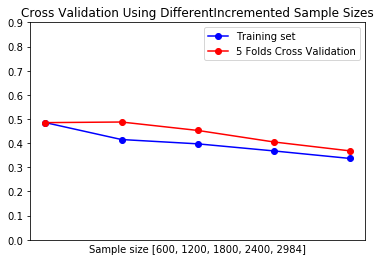

In [449]:
#Cross validation using sample size 
tsco=[]
cssco=[]

for i in list(range(600, len(Xtrain)+600,600)):
    
    if i > len(Xtrain):
        i=len(Xtrain)
    GB=GradientBoostingClassifier(n_estimators=100, min_samples_leaf=500, max_depth=1).fit(Xtrain[0:i][bestFeatures], YYtrain[0:i])
    
    tsco.append(GB.score(X=Xtrain[0:i][bestFeatures], y=YYtrain[0:i]))    
    cssco.append(cross_val_score(cv=5, estimator=GB, X=Xtrain[0:i][bestFeatures], y=YYtrain[0:i]).mean())
    
plt.plot(1-pd.Series(tsco), "o-", c="blue", label="Training set")
plt.plot(1-pd.Series(cssco), "o-", c="red", label="5 Folds Cross Validation")
#plt.plot(1-pd.Series(tesco), "o-", c="green", label = "test set")
plt.legend()
plt.xlabel("Sample size [600, 1200, 1800, 2400, 2984]")
plt.yticks(np.arange(0.0,1.0, 0.1))
plt.tick_params(axis='x',bottom='off',labelbottom='off')
#plt.xticks(np.arange(0.0,len(Xtrain), 600))
#plt.xticks(list(range(300, len(Xtrain)+244,300)))
plt.title("Cross Validation Using DifferentIncremented Sample Sizes")
plt.show()

====================================================== <br>
Accuracy score of test/unseen data 
<br>====================================================== <br>

In [450]:
#Test Set Score & Confusion Matrix
print("=======\nUnseen test set score: %f"%(GB.score(Xtest[bestFeatures],YYtest)))
print("=======\nConfusion Matrix")
pd.DataFrame(confusion_matrix(y_pred=GB.predict(X=Xtest[bestFeatures]), y_true=YYtest))

Unseen test set score: 0.746177
Confusion Matrix


,0,1
0,117,42
1,41,127


<br>====================================================== <br>
ROC Curve
<br>====================================================== <br>

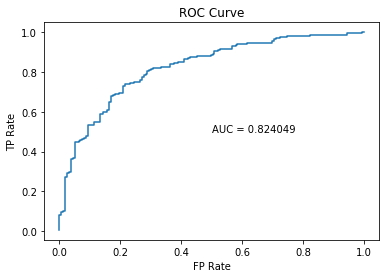

In [451]:
#ROC Curve
tpr,fpr, thr = metrics.roc_curve(y_score=[i[1] for i in GB.predict_proba(Xtest[bestFeatures])], y_true=YYtest)
plt.plot(tpr,fpr)
plt.title("ROC Curve")
plt.ylabel("TP Rate")
plt.xlabel("FP Rate")
plt.text(0.5,0.5,"AUC = %f"%(metrics.roc_auc_score(y_score=[i[1] for i in GB.predict_proba(Xtest[bestFeatures])], y_true=YYtest)))
plt.show()

<br>====================================================== <br>Does the model perform differently in different time periods?
...NO!<br>====================================================== <br>

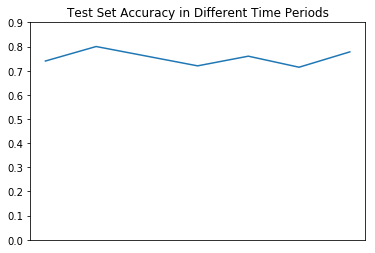

In [452]:
#How well does the model perform in different periods of time
hh=GB.predict(X=Xtest[bestFeatures])

z = YYtest==hh

c=[0,50]
xx=[]
for i in list(range(0, len(z), 50)):
    if not c[1]+50 <=len(z):
        c[1]=len(z)
        
    xx.append(z[c[0]:c[1]].mean())
    c[0]=c[0]+50
    c[1]=c[1]+50

plt.figure()
plt.plot(xx)
plt.yticks(np.arange(0.0,1.0, 0.1))    
plt.tick_params(axis='x',bottom='off',labelbottom='off')
plt.title("Test Set Accuracy in Different Time Periods")

plt.show()


<br>====================================================== <br>
If you are implementing the model in your trading strategy, at what prediction probability threshold you can trust it?<br>
The table below can help you choose 
<br>====================================================== <br>

In [453]:
#
probs = GB.predict_proba(Xtest[bestFeatures])
probs = pd.DataFrame(probs)
probs = pd.concat([YYtest,probs,pd.Series(probs[1]>0.5), YYtest == pd.Series(probs[1]>0.5) ], axis=1)
probs.columns=['Ytrue', 'p0','p1','pred','e' ]
confmat = pd.concat([pd.DataFrame(probs[(probs.e)& (probs.pred)].p1.describe()),pd.DataFrame(probs[(probs.e==1)& (probs.pred==0)].p0.describe()),pd.DataFrame(probs[(probs.e==0)& (probs.pred)].p1.describe()),pd.DataFrame(probs[(probs.e==0)& (probs.pred==0)].p0.describe())], axis=1)
confmat.columns=["True Positives", "True Negatives", "False Positives", "False Negatives"]


#Prediction probabilities
pr = [(0.5  ,  0.5+(0.5/3)),(0.5+(0.5/3),  0.5+(0.5/3)+(0.5/3)),(0.5+(0.5/3)+(0.5/3), 0.5+(0.5/3)+(0.5/3)+(0.5/3))]
truepred=[]
falsepred=[]
for thhr,thhr2 in pr:
    truepred.append(probs[ (probs.e) & ( ( (probs.pred) & ((probs.p1 >=thhr) &(probs.p1 <thhr2) )) |  ( (probs.pred ==0) & (probs.p0>=thhr) &(probs.p0 <thhr2) )  ) ].count()[1])
    falsepred.append(probs[ (probs.e==0) & ( ( (probs.pred) & ((probs.p1 >=thhr) &(probs.p1 <thhr2) )) |  ( (probs.pred ==0) & (probs.p0>=thhr) &(probs.p0 <thhr2) )  ) ].count()[1])
    
probacc=pd.DataFrame([i for i in zip(truepred,falsepred)])

probacc= pd.concat([probacc, pd.DataFrame(probacc[[0]].values/(probacc[[0]].values+probacc[[1]].values))],axis=1)
probacc.columns=["True Predictions","False Predictions","True Prediction Rate"]
probacc.index=["%f - %f "%(pr[0][0], pr[0][1]),"%f - %f "%(pr[1][0], pr[1][1]),"%f - %f "%(pr[2][0], pr[2][1])]
probacc.index.name="Prediction Probability Range"
probacc

,True Predictions,False Predictions,True Prediction Rate
Prediction Probability Range,,,
0.500000 - 0.666667,125,68,0.647668
0.666667 - 0.833333,112,14,0.888889
0.833333 - 1.000000,7,1,0.875000


<br>====================================================== <br>
**Notes:**

* Different feature selection & extraction techniques such as RFE, P-values, quantiling, PCA and selecting highly correlated features were tested but this model achieved best results.
* Observations are balanced and test set was totally unseen so the accuracy achieved is true, no tricks played.
* The model was tested on different currency (USD/EUR), it achieved similar results.


In [454]:
%store bestFeatures
%store Xtrain
%store YYtrain
%store Xtest
%store YYtest
%store GB
%store probacc
%store probs


Stored 'bestFeatures' (Series)
Stored 'Xtrain' (DataFrame)
Stored 'YYtrain' (Series)
Stored 'Xtest' (DataFrame)
Stored 'YYtest' (Series)
Stored 'GB' (GradientBoostingClassifier)
Stored 'probacc' (DataFrame)
Stored 'probs' (DataFrame)
